# Time series Forecasting

__Notebook overview__:

- Task description
- First look at Data
- Explore the data
- Correlation analysis
- Split data
- Training
- Prediction and evaluation

## Task description
 
We want to develop a model to forecast the one hour ahead electricity load based on the hourly electricity load and temperature data.

## First look at Data

We use the data from the [Global Energy Forecasting Competition](https://en.wikipedia.org/wiki/Global_Energy_Forecasting_Competition). We focus on the data for the year 2014 which contains 8'760 observations. The dataset has been downloaded for you and is available in the *data* folder.

In [1]:
# Load settings and functions
%run tools.py

In [2]:
df = load_data()

Data loaded.
Data size: (8760, 2)


Let's have a close look at the dataset.

In [3]:
info_data(df)

Frequency of observations:  H
---------------------------------------
Number of days:  365
Number of month:  12
---------------------------------------
First month:  January
Last month:  December
---------------------------------------
Available variables:  ['electric load', 'temperature']
variable types: [dtype('float64'), dtype('float64')]
---------------------------------------
Number of missing hours:  [0, 0]


Let's have a look at a few rows from the dataset.

In [4]:
df.head(5)

,electric load,temperature
timestamp,,
2014-01-01 00:00:00,3295.0,-12.592593
2014-01-01 01:00:00,3173.0,-11.851852
2014-01-01 02:00:00,3085.0,-12.777778
2014-01-01 03:00:00,3053.0,-12.777778
2014-01-01 04:00:00,3077.0,-13.333333


## Explore the data

Now, let's visualise the electric loads and the temperature. Note that due to the centric role of the time dimension in time series data one should explore the dynamics of the features and the target over time (__trends and cycles__). Also, one should check how the target is correlated with its own values in the past (__temporal dependencies__). Finally, one should be mindful of the changes in the distribution of the data over time (__stationarity__). Since our data is stationary, we only check the trends, cycles and temporal dependencies in the following.

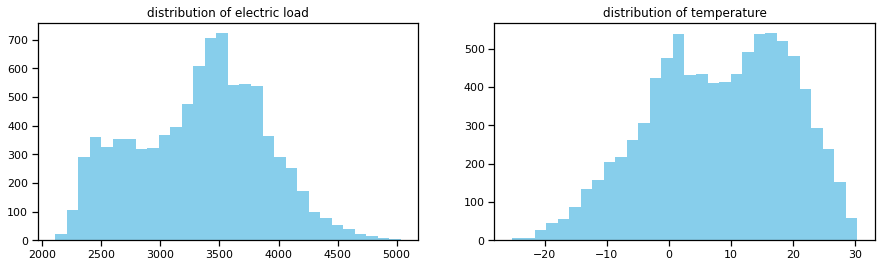

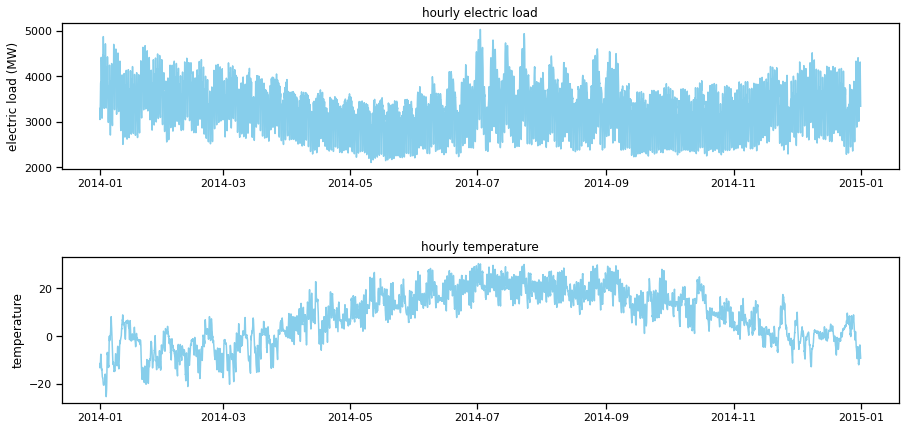

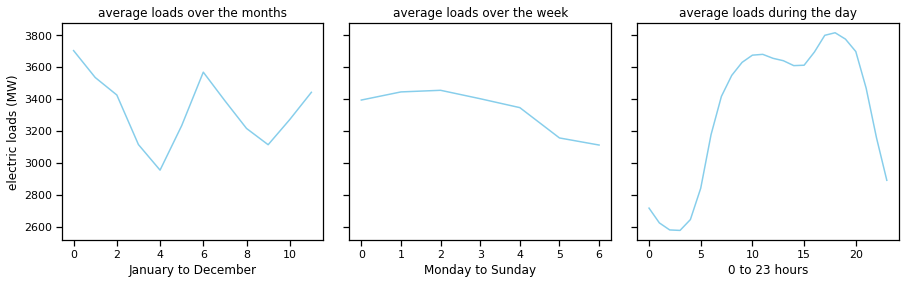

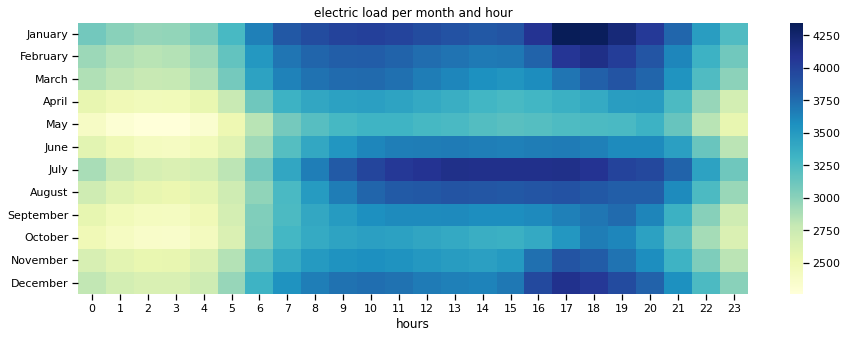

In [5]:
plot_data(df)

<div class="alert alert-success">
<h3>Questions</h3>
    
__Q1.__ How do the distributions look like in the 1st row of plots?<br>
    
__Q2.__ What is the common characteristic of the electric load and temperature dynamics in the 2nd and 3rd rows of plots?<br>
    
__Q3.__ Looking at the 4th row, does electric load remain constant during the week? How about nights versus daytime?<br>
    
__Q4.__ What do you learn from the heatmap in the last row? Are months of the year relevant in the intensity of electric loads from 6:00 am to midnight?

    
    
 💡 Answers to these questions help building the modeling strategy.
    
</div>

### Answers

__Q1.__ Both are bimodal distributions meaning that data are centered around two values (e.g. ~0 and ~18 for the temperature). <br>

__Q2.__ As expected, both electric load and temperature time-series show seasonal trends meaning that there are regular repetitions of patterns over time. Therefore, in general, the time could provide a basis for our expectation of the electric load. For instance, the plot in the second row shows that the load is higher at the beginning, middle, and end of the year when the weather is either too cold or too hot.<br>

__Q3.__ The plots in the fourth row show that the electric load is higher during the weekdays (compared to the weekends) and during the daytime (compared to the nights). Therefore, it makes sense to keep these features and use them in our models. <br>

__Q4.__ The heatmap shows that from 1 am to 5 am the month doesn't matter much. However, since 6 am demand for the electricity depends on the month. So the answer is yes, the month matters for the loads during the day. We concude that the interactions of time features (hour and month) could also matter for the electric load. 

## Correlation analysis
Here, we create two features that can play a big role in forecasting the load. One simple conjecture is that the past values of the load and temperature can predict the load. Our data has an hourly frequency and our objective is to predict the load one hour ahead. Therefore, we create lags of the load and temperature, and then check the correlations and auto-correlations.

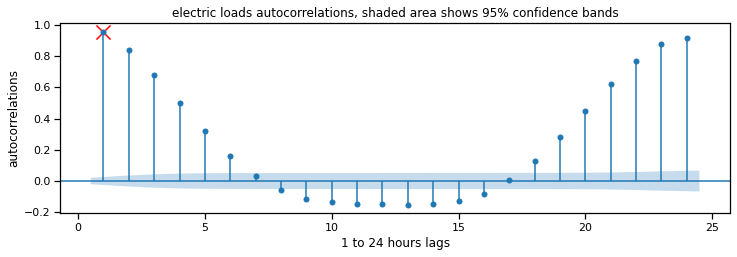

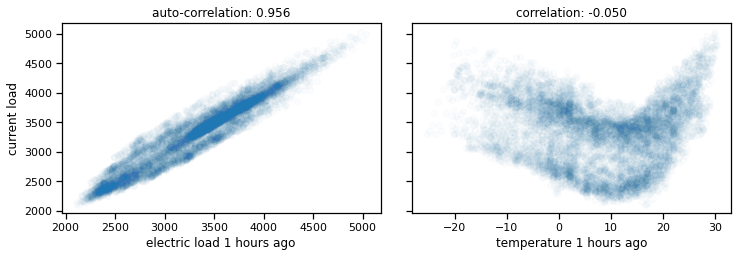

In [6]:
plot_corr(df, n_lags=1) # n_lag is between 1 and 24 hours

<div class="alert alert-info">
    
Let's change the number of lags `n_lags` in the correlation analysis `plot_corr()`.<br>
    
 💡 **Tip:** You can use the shortcuts `C` and `V` (or the `Edit` tab) to place a copy of the cell right below the original and then compare two different values for `n_lags`.<br>
    
</div>

<div class="alert alert-success">
<h3>Questions</h3>
    
__Q5.__ If you were to predict the current load based on the past, which of the past values you would select?
    
__Q6.__ Do you observe a linear relationship between the current load the load 1 hours ago?<br>
    
__Q7.__ Do you observe a linear relationship between the current load the  temperature 1 hours ago?

    
 💡 Answers to these questions help building the modeling strategy.
    
</div>

### Answers

__Q5.__ The auto-correlation plot shows that the load is auto-correlated with many lagged loads. But the 1st lag leads to the highest auto-correlation for the electric load. So, the load from previous hour can best represent the current load. <br>

__Q6.__ Yes, their relation is shown with a straight line, so it is linear. It also indicates that the load one hour in the past is a strong predictor of the load.<br>

__Q7.__ No, unlike the previous case, it is not linear. So, a linear model cannot probably best capture this relation.

## Split data
Let's split the data set. We use the last month of the data, i.e. December, for testing and the rest of the data, that is January to November, for training and validations.

Train data from 2014-Jan to 2014-Nov (8015, 6)
Test data 2014-Dec (744, 6)


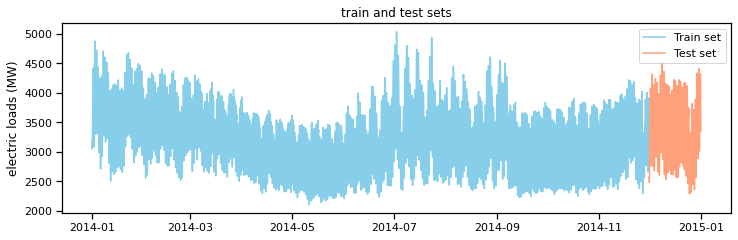

In [7]:
# Train/test splitting
train, test = sample_split(df)

## Training
Based on the correlation analysis, we decide to use the 1st lags of the load and temperature as features in our model. We also have the insight that these features are related to the target in both linear and non-linear ways. Therefore, we build linear and non-linear models to predict the one-hour-ahead electric load. 

We choose either of the ridge regression or random forest as the machine learning model. Note that each model requires an appropriate preprocessing of the features. For instance, the ridge regression requires the continuous features to be scaled, and both models require one-hot encoding of the categorical features.

Preprocessing data is done!
Cross-validation is setup!
Grid search is setup!
Training with grid search and cross-validation is done!
A total of 100 models were fitted


Here is the results of grid search:




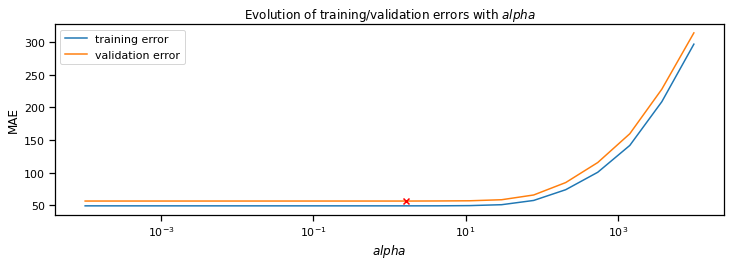

In [8]:
# Fit a ridge regression or a random forest model on the train data
model = train_model(train, select_model='regression') # select_model = 'regression' or 'randomforest'

<div class="alert alert-success">
<h3>Questions</h3>
    
__Q8.__ What do you observe in the plot when you select the ridge regression? Does the error remain constant by changing $\alpha$? <br>
    
__Q9.__ Which of the curves indicate a better performance (or smaller error), training or validation? What does the gap between the two indicate?
    
</div>

### Answers

__Q8.__ No, the error measured by MAE is not constant. It increases by $\alpha$. Larger values of $\alpha$ don't allow the model to fully benefit from the features. So the performance become progressively worse.<br>

__Q9.__ The validation error is higher than the training error, indicating that the model overfits. One possible explanation for this issue is in the structure and size of the data set. More precisely, since the validation set (e.g. July) always comes ahead of the train set (e.g. January to June), the model cannot generalize to the attributes that are specific to July. A solution for this issue is to increase the size of the train set, e.g. training the model on a full year.

## Prediction and evaluation
The first step here is to define our evaluation metric and baseline. We choose the **mean absolute error (MAE) as the metric** and **the median as the baseline**. Note that you can even consider the loads from the previous hour as a prediction for the current load without any modeling. In other words, **the lagged loads  can act as a (smart) baseline before building any model**. Below, you can see how the performance of such a baseline can be compared with the statistical baseline and our models.

Let's evaluate the performance of the model we previously chose by `select_model` and train it.

simple baseline MAE: 455
smart baseline MAE: 131
ridge regression MAE: 52




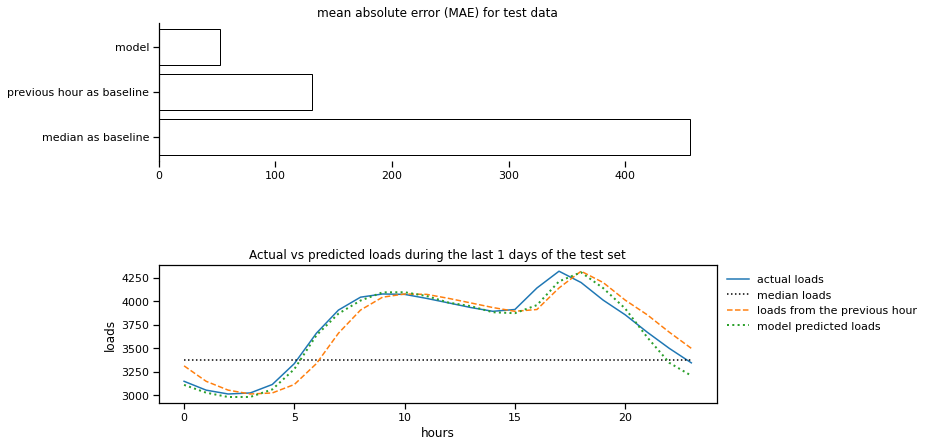

In [9]:
# evaluate the model performance  
# n_days shows the actual and predicted values for the number of days that you select
# n_days takes values between 1 and 31
evaluate_model(model, train, test, n_days=1) 

The first plot show that the model doesn't remarkably outperform the smart baseline as it does to the first baseline i.e. median. This is a common situation for time series data with high auto-correlation which may put machine learning models in time series analysis in difficult position to be justified and deployed. 

In the second plot we show the predicted load with the model of your choice in `select_model` along with the observed loads in the test set for the period of `n_days`. The plot also shows the two baselines.

Note that our objective was to build models that can predict the electric loads one hour ahead. But you can develop a setup where you can change the prediction horizon to be more than only one hour. Deciding about the prediction horizon depends on the domain, the problem that is intended to be solved, and the added value of the machine learning project.

<div class="alert alert-info">

Let’s compare the ridge regression and the random forest model. <br>
    
1. Go back to the subsection **Training** and change the `select_model`-parameter inside the `train_model`-function to `'randomforest'` (Careful you need the quotation marks).<br>
    
2. Run `evaluate_model` again and compare the results.
    
 💡 **Tip:** You can use the shortcuts `C` and `V` (or the `Edit` tab) to place copies of the two elevant cells below this task to make the comparison of the performances easier.
</div>

<div class="alert alert-success">
<h3>Questions</h3>
    
__Q10.__ What is the idea behind having a baseline? 
    
__Q11.__ Which of the two baselines you would use? Does the ridge regression beat the two baselines? <br>
    
__Q12.__ Which of the ridge regression or random forest has better performance on the test data?

</div>

### Answers

__Q10.__ The idea is to see if we can avoid building any model but still come with some crude prediction. More precisely, we want to see if we can rely on the past information as a proxy for what comes in the future without using any machine learning techniques. Here we use the median of the loads in the training set and find it to be 455 Megawatt away from the electric load in the test set which is not bad but still, it is worth seeing if we can get more accurate predictions. An alternative is to use the lagged loads which are 131 Megawatt away from the electric load in the test set. That is a lot better. <br>

__Q11.__ I would use the smart baseline as it beats the median. Yes, the ridge regression beats both.

__Q12.__ The random forest has better performance on the test data. Its MAE is less than that of ridge regression which is 52.